In [1]:
#!pip install git+https://github.com/lionfish0/download_thingspeak.git`

In [34]:
!rm channel*

In [ ]:
from download_thingspeak import download
import pandas as pd
#PMS5003
pms5003 = pd.DataFrame(download('http://thingspeak.com/channels/718028',verbose=True))#,cacheonly=True)) #https://thingspeak.com/channels/718028
#?
alphasenseN2 = pd.DataFrame(download('http://thingspeak.com/channels/295702',verbose=True))#,cacheonly=True)) #https://thingspeak.com/channels/295702

pms5003['created_at'] = pd.to_datetime(pms5003['created_at'])
for i in range(1,5):
    pms5003['field%d' % i] = pd.to_numeric(pms5003['field%d' % i])
    alphasenseN2['field%d' % i] = pd.to_numeric(alphasenseN2['field%d' % i])
alphasenseN2['created_at'] = pd.to_datetime(alphasenseN2['created_at'])
#TODO Should deal with timezones properly, they're a bit of a mess
#this will do.
alphasenseN2['created_at'] = alphasenseN2['created_at']+pd.Timedelta(3,'h') #.tz_convert(None)
pms5003['created_at']=pms5003['created_at']+pd.Timedelta(3,'h')

Ignoring/overwriting cache
Using 0 records from cache
Loading from http://thingspeak.com/channels/718028/feeds/entry/1.json
Loading from http://thingspeak.com/channels/718028/feeds/entry/8000.json


In [3]:
import pandas as pd
tno4036data = pd.read_csv('TNO4036.csv')
tno4036data['TimeStamp'] = pd.to_datetime(tno4036data['TimeStamp'].str.replace('/20','-').str.replace('/','-'),format='%d-%m-%y %H:%M')
tno4036data=tno4036data.drop(tno4036data.index[5238:5274])

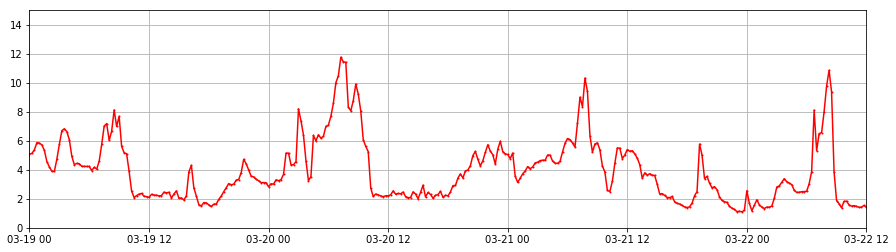

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[15,4])
def plot(x,y,m,ylim,scale,offset):
    plt.plot(x,y*scale+offset,m,markersize=2,alpha=1)
    plt.xlim([pd.to_datetime('2019-03-19 00:00+00:00'),pd.to_datetime('2019-03-22 12:00+00:00')])
    plt.ylim([0,ylim])
    plt.grid()
    
#plt.subplot(3,1,1)
plot(pms5003['created_at'],pms5003['field1'],'b.',50,0.12,0)
plot(pms5003['created_at'],pms5003['field3'],'k.',50,0.12,0)
#plot(alphasenseN2['created_at'],alphasenseN2['field2'],'g.',15,0.4,0)
plot(tno4036data['TimeStamp'],tno4036data['PM2.5 particles (ug/m^3)'],'.-r',15,1,0)

In [5]:
pms5003['seconds'] = (pms5003['created_at']-pd.to_datetime('2019-03-19 00:00+00:00')).dt.total_seconds() #,pms5003['field1']
tno4036data['seconds'] = (tno4036data['TimeStamp']-pd.to_datetime('2019-03-19 00:00')).dt.total_seconds() #,pms5003['field1']

In [6]:
import numpy as np
pms = np.c_[pms5003['seconds'].values/3600,pms5003['field1'].values]
tno = np.c_[tno4036data['seconds'].values/3600,tno4036data['PM2.5 particles (ug/m^3)'].values]
pms = pms[(pms[:,0]>=0) & (pms[:,0]<(24*3))]
tno = tno[(tno[:,0]>=0) & (tno[:,0]<(24*3))]

In [7]:
lowres = []
stepsize = 3
periods = np.arange(0,24*5,stepsize)
for step in periods:
    lowres.append([step,np.mean(tno[(tno[:,0]>=step) & (tno[:,0]<step+stepsize),1])])
lowres = np.array(lowres)
lowres = lowres[~np.isnan(lowres[:,1]),:]

/home/mike/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mike/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
lowres

array([[ 0.        ,  4.9725    ],
       [ 3.        ,  5.24      ],
       [ 6.        ,  5.7325    ],
       [ 9.        ,  3.61416667],
       [12.        ,  2.29916667],
       [15.        ,  2.32416667],
       [18.        ,  2.3375    ],
       [21.        ,  3.60666667],
       [24.        ,  3.835     ],
       [27.        ,  5.97333333],
       [30.        ,  9.46416667],
       [33.        ,  4.19083333],
       [36.        ,  2.305     ],
       [39.        ,  2.30833333],
       [42.        ,  3.6275    ],
       [45.        ,  5.08583333],
       [48.        ,  4.1425    ],
       [51.        ,  4.805     ],
       [54.        ,  7.11333333],
       [57.        ,  4.4075    ],
       [60.        ,  4.33916667],
       [63.        ,  2.03      ],
       [66.        ,  2.9725    ],
       [69.        ,  1.57416667]])

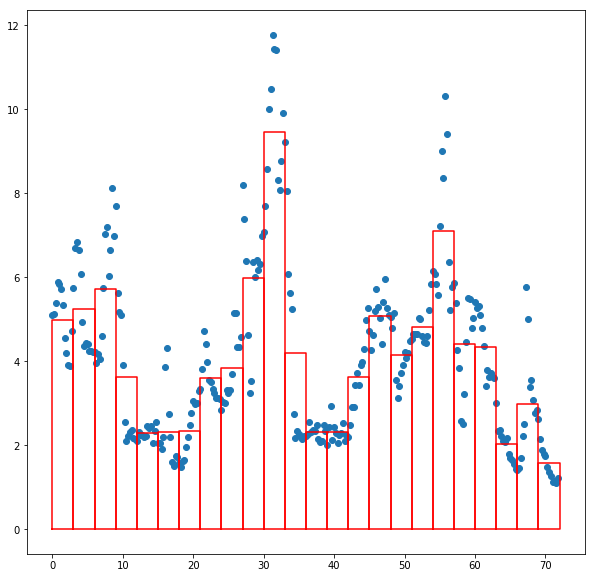

In [9]:
plt.figure(figsize=[10,10])
plt.scatter(tno[:,0],tno[:,1])
for lr in lowres:
    plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')

In [10]:
X1 = np.c_[lowres[:,0]+stepsize,lowres[:,0],np.zeros(len(lowres))]
Y1 = lowres[:,1:2]*stepsize

In [11]:
#X2 = np.c_[pms[:,0],np.full(len(pms),np.NaN),np.ones(len(pms))] #maybe need to use another integral
integrationperiod = 60/3600 #np.mean(np.diff(pms[:,0])) #really should find out this
fullX2 = np.c_[pms[:,0]+integrationperiod,pms[:,0],np.zeros(len(pms))] 
fullY2 = pms[:,1:2]*integrationperiod

In [12]:
X2 = []
Y2 = []
stepdown = 5
for i in range(0,len(fullX2)-stepdown,stepdown):
    X2.append([fullX2[i+stepdown-1,0],fullX2[i,1]])
    Y2.append(np.sum(fullY2[i:i+stepdown]))
X2 = np.array(X2)######<<<<<<<<<<<<<<<<<TO DECIDE
X2 = np.c_[X2,np.zeros(len(X2))]
Y2 = np.array(Y2)

In [13]:
tnointegrationperiod = np.median(np.diff(tno[:,0]))
testX1 = np.c_[tno[:,0]+tnointegrationperiod,tno[:,0],np.zeros(len(tno))]
testY1 = tno[:,1]

(0, 20)

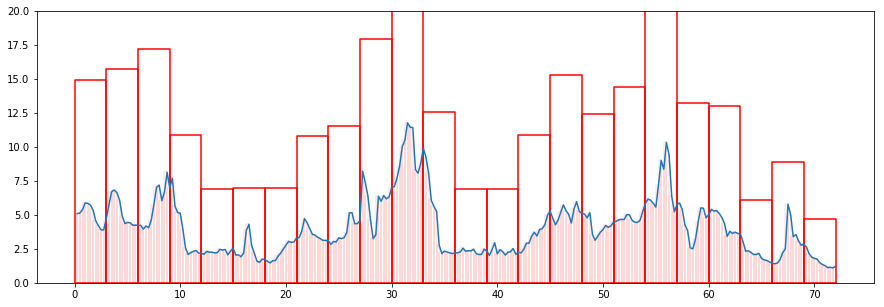

In [14]:
plt.figure(figsize=[15,5])
#plt.plot(X1,Y1/3,'b-')
for x,y in zip(X1,Y1):
    plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y,y,0],'r-')
for x,y in zip(testX1,testY1):
    plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y,y,0],'r-',alpha=0.1)    
plt.plot(X2,Y2,'.r',markersize=1)
plt.plot(testX1[:,0],testY1)
plt.ylim([0,20])

# Analysis

In [15]:
import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from HetMOGP.util import draw_mini_slices
from HetMOGP.het_likelihood import HetLikelihood
#from hetmogp.model import HetMOGP
from HetMOGP.svmogp import SVMOGP
#from hetmogp import multi_output
from HetMOGP import util
from HetMOGP.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import GPy
import matplotlib.pyplot as plt

In [16]:
from HetMOGP.likelihoods.bernoulli import Bernoulli
from HetMOGP.likelihoods.gaussian import Gaussian
from HetMOGP.likelihoods.categorical import Categorical
from HetMOGP.likelihoods.hetgaussian import HetGaussian
from HetMOGP.likelihoods.beta import Beta
from HetMOGP.likelihoods.gamma import Gamma
from HetMOGP.likelihoods.exponential import Exponential

In [17]:
M = 10  # number of inducing points
Q = 1  # number of latent functions

# Heterogeneous Likelihood Definition
# likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
#likelihoods_list = [Bernoulli(), Bernoulli()] # Real + Binary
likelihoods_list = [Gaussian(sigma=0.1),Gaussian(sigma=0.01)]

likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

#W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)
W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)



In [18]:
#X2 = X2[0:1,:]
#Y2 = Y2[0:1]

In [19]:
X = [X1,X2]
Y = [Y1,Y2]

In [20]:
air_pollution_demo_data = {'X':X,'Y':Y,'testX':testX1,'testY':testY1}
import pickle
pickle.dump(air_pollution_demo_data,open('air_pollution_demo_data.p','wb'))


In [21]:
from HetMOGP.error_func import snlp, smse, mae

In [22]:
# KERNELS
input_dim = 3
Q = 1
ls_q = np.array(([2.0]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lengthscale=[ls_q], variance=[var_q], input_dim=input_dim,kernel=GPy.kern.Mix_Integral_)

#kern_list = [GPy.kern.Mix_Integral_]

def callback(i):
    print(i)
    if i['n_iter'] > 4000:
        return True
    return False

X_ = np.vstack((X[0], X[1]))
from sklearn.cluster import KMeans
#kmeans_X = KMeans(n_clusters=100, random_state=0).fit(X_)
#Z = kmeans_X.cluster_centers_
Ninducing = 500
Z = np.zeros([Ninducing,X_.shape[1]])
Z[:,-1] = 1
Z[:,0] = np.linspace(0,24*5,Ninducing)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=70)
model.Z.fix()

In [ ]:
model.kern.lengthscale.fix(0.5)
model.kern.variance = 5000 #.fix(5000)
model.kern_q0.lengthscale.fix(0.5)
model.kern_q0.variance = 5000#.fix(5000)

In [ ]:
#vem_model=VEM(model,vem_iters=30,maxIter_perVEM=30,optZ=False,verbose=True,verbose_plot=False,non_chained=True)
import climin
opt = climin.Adam(model.optimizer_array,model.stochastic_grad,step_rate=0.1,decay_mom1=1-0.9, decay_mom2=1-0.999)
opt.minimize_until(callback)

In [ ]:
plt.figure(figsize=[15,12])
plt.subplot(2,1,1)
plt.plot(X2[:,0],Y2/np.median(X2[:,0]-X2[:,1]),'g-')
plt.title('Colocated low-cost sensor')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.title('Reference sensor data and prediction')
means,variances = model.predict(testX1)
mean = means[0]
var = variances[0]
plt.plot(testX1[:,0],4*mean,'b-',label='prediction')
plt.plot(testX1[:,0],4*mean+4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX1[:,0],4*mean-4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX1[:,0],testY1,'r-',label='true') #test data red line

lab = 'training data'
for x1,y1 in zip(X1,Y1):
    #plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')
    plt.plot([x1[0],x1[0]-stepsize,x1[0]-stepsize,x1[0],x1[0]],[0,0,y1/3,y1/3,0],'r-',label=lab)
    lab = None
plt.legend()
plt.grid()
plt.vlines(model.Z,0,1)
plt.ylim([0,20])
plt.xlim([X[0][0,1],X[0][-1,0]])

In [ ]:
np.mean(np.abs(testY1 - mean[:,0]))

In [ ]:
#3.449975592412143 [no extra data]
#3.4329467097085566

In [ ]:
model